# LSTM Cell Writeup

# LSTM Cell Code

In [1]:
# Standard library
import os

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Deep learning
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Dataset

# Preprocessing
from sklearn.preprocessing import MinMaxScaler

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



Using device: cpu


/home/atharva/Documents/sync/school/02_spring25/intro_to_deep_learning/intro-to-deep-learning/final_project/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
import torch
import numpy as np
import pandas as pd
import os
from torch.utils.data import TensorDataset, DataLoader

# Directory containing your CSV files
data_directory = "data/Car_data/car_data"  # Replace with your directory path

X_data = []  # Input sequences (first 62 rows)
y_data = []  # Target sequences (last 5 rows)

# Loop through all CSV files in the directory
for filename in os.listdir(data_directory):
    if filename.endswith('.csv'):
        file_path = os.path.join(data_directory, filename)
        
        # Read the CSV file
        df = pd.read_csv(file_path)
        
        # Convert DataFrame to numpy array
        file_data = df.values
        
        # Split into input and target sequences
        if len(file_data) >= 67:  # Ensure file has at least 67 rows
            X_data.append(file_data[:62])
            y_data.append(file_data[62:67])  # Explicitly get rows 62-66 (5 rows)
        else:
            print(f"Warning: File {filename} has fewer than 67 rows and will be skipped.")

# Convert to tensors - reshape to [samples, time steps, features]
X_tensor = torch.FloatTensor(np.array(X_data))  # Shape: [num_files, 62, num_features]
y_tensor = torch.FloatTensor(np.array(y_data))  # Shape: [num_files, 5, num_features]

# Create dataset and dataloader
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=128, shuffle=False)  # shuffle=False for time series

print(f"Loaded {len(X_data)} files for training")
print(f"Input shape: {X_tensor.shape}")
print(f"Target shape: {y_tensor.shape}")
from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split

# First split data into temp (train+validation) and test
X_temp, X_test, y_temp, y_test = train_test_split(X_tensor.numpy(), y_tensor.numpy(), 
                                                  test_size=0.15, random_state=42)

# Then split the temp data into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, 
                                                  test_size=0.176, random_state=42)  
# 0.176 of 85% is ~15% of the original dataset

# Convert back to tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create dataloaders
batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training set: {X_train_tensor.shape}, {y_train_tensor.shape}")
print(f"Validation set: {X_val_tensor.shape}, {y_val_tensor.shape}")
print(f"Test set: {X_test_tensor.shape}, {y_test_tensor.shape}")



Loaded 9400 files for training
Input shape: torch.Size([9400, 62, 12])
Target shape: torch.Size([9400, 5, 12])
Training set: torch.Size([6583, 62, 12]), torch.Size([6583, 5, 12])
Validation set: torch.Size([1407, 62, 12]), torch.Size([1407, 5, 12])
Test set: torch.Size([1410, 62, 12]), torch.Size([1410, 5, 12])


In [3]:
class LSTM_custom(nn.Module):
    def __init__(
        self,
        input_size=12,
        hidden_size=64,
        num_layers=1,
        sequence_length=62,
        dropout=0.2,
    ):
        super(LSTM_custom, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.projection_layer = nn.Linear(self.hidden_size, input_size)

        # Input gate
        self.W_xi = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(input_size, hidden_size)))
        self.b_xi = nn.Parameter(torch.zeros(hidden_size))
        self.W_hi = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(hidden_size, hidden_size)))
        self.b_hi = nn.Parameter(torch.zeros(hidden_size))

        # Forget gate
        self.W_xf = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(input_size, hidden_size)))
        self.b_xf = nn.Parameter(torch.zeros(hidden_size))
        self.W_hf = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(hidden_size, hidden_size)))
        self.b_hf = nn.Parameter(torch.zeros(hidden_size))

        # Cell gate
        self.W_xg = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(input_size, hidden_size)))
        self.b_xg = nn.Parameter(torch.zeros(hidden_size))
        self.W_hg = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(hidden_size, hidden_size)))
        self.b_hg = nn.Parameter(torch.zeros(hidden_size))

        # Output gate
        self.W_xo = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(input_size, hidden_size)))
        self.b_xo = nn.Parameter(torch.zeros(hidden_size))
        self.W_ho = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(hidden_size, hidden_size)))
        self.b_ho = nn.Parameter(torch.zeros(hidden_size))

    def input_gate(self, x_t, h_prev):
        return torch.sigmoid(
            torch.matmul(x_t, self.W_xi) + self.b_xi + torch.matmul(h_prev, self.W_hi) + self.b_hi
        )

    def forget_gate(self, x_t, h_prev):
        return torch.sigmoid(
            torch.matmul(x_t, self.W_xf) + self.b_xf + torch.matmul(h_prev, self.W_hf) + self.b_hf
        )

    def cell_gate(self, x_t, h_prev):
        return torch.tanh(
            torch.matmul(x_t, self.W_xg) + self.b_xg + torch.matmul(h_prev, self.W_hg) + self.b_hg
        )

    def output_gate(self, x_t, h_prev):
        return torch.sigmoid(
            torch.matmul(x_t, self.W_xo) + self.b_xo + torch.matmul(h_prev, self.W_ho) + self.b_ho
        )

    def lstm_cell(self, x_t, h_prev, c_prev):
        i_t = self.input_gate(x_t, h_prev)
        f_t = self.forget_gate(x_t, h_prev)
        g_t = self.cell_gate(x_t, h_prev)
        o_t = self.output_gate(x_t, h_prev)

        c_t = f_t * c_prev + i_t * g_t
        h_t = o_t * torch.tanh(c_t)

        return h_t, c_t

    def forward(self, x):
        batch_size, seq_len, feature_dim = x.size()
        h_t = torch.zeros(batch_size, self.hidden_size, device=x.device)
        c_t = torch.zeros(batch_size, self.hidden_size, device=x.device)

        # Process the input sequence
        for t in range(seq_len):
            h_t, c_t = self.lstm_cell(x[:, t, :], h_t, c_t)

        # Generate predictions
        predictions = []
        current_x = x[:, -1, :]  # Start with the last input

        for i in range(5):
            h_t, c_t = self.lstm_cell(current_x, h_t, c_t)
            # Project hidden state to feature dimension
            output = self.projection_layer(h_t)
            predictions.append(output)
            current_x = output  # Use the prediction as the next input

        # Stack predictions along sequence dimension
        return torch.stack(predictions, dim=1)


In [4]:
# class LSTM_custom(nn.Module):
#     def __init__(
#         self,
#         input_size=12,
#         hidden_size=64,
#         num_layers=1,
#         sequence_length=62,
#         dropout=0.2,
#     ):
#         super(LSTM_custom, self).__init__()
#         self.input_size = input_size
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.projection_layer = nn.Linear(self.hidden_size, input_size)

#         # Combined input+hidden dimension
#         combined_dim = input_size + hidden_size
        
#         # Input gate
#         self.W_i = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(combined_dim, hidden_size)))
#         self.b_i = nn.Parameter(torch.zeros(hidden_size))
        
#         # Forget gate
#         self.W_f = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(combined_dim, hidden_size)))
#         self.b_f = nn.Parameter(torch.ones(hidden_size))  # Initialize to 1 for better gradient flow
        
#         # Cell gate
#         self.W_g = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(combined_dim, hidden_size)))
#         self.b_g = nn.Parameter(torch.zeros(hidden_size))
        
#         # Output gate
#         self.W_o = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(combined_dim, hidden_size)))
#         self.b_o = nn.Parameter(torch.zeros(hidden_size))

#     def input_gate(self, x_t, h_prev):
#         # Concatenate input and hidden state
#         combined = torch.cat([x_t, h_prev], dim=1)
#         return torch.sigmoid(torch.matmul(combined, self.W_i) + self.b_i)

#     def forget_gate(self, x_t, h_prev):
#         combined = torch.cat([x_t, h_prev], dim=1)
#         return torch.sigmoid(torch.matmul(combined, self.W_f) + self.b_f)

#     def cell_gate(self, x_t, h_prev):
#         combined = torch.cat([x_t, h_prev], dim=1)
#         return torch.tanh(torch.matmul(combined, self.W_g) + self.b_g)

#     def output_gate(self, x_t, h_prev):
#         combined = torch.cat([x_t, h_prev], dim=1)
#         return torch.sigmoid(torch.matmul(combined, self.W_o) + self.b_o)

#     def lstm_cell(self, x_t, h_prev, c_prev):
#         i_t = self.input_gate(x_t, h_prev)
#         f_t = self.forget_gate(x_t, h_prev)
#         g_t = self.cell_gate(x_t, h_prev)
#         o_t = self.output_gate(x_t, h_prev)

#         c_t = f_t * c_prev + i_t * g_t
#         h_t = o_t * torch.tanh(c_t)

#         return h_t, c_t

#     def forward(self, x):
#         batch_size, seq_len, feature_dim = x.size()
#         h_t = torch.zeros(batch_size, self.hidden_size, device=x.device)
#         c_t = torch.zeros(batch_size, self.hidden_size, device=x.device)

#         # Process the input sequence
#         for t in range(seq_len):
#             h_t, c_t = self.lstm_cell(x[:, t, :], h_t, c_t)

#         # Generate predictions
#         predictions = []
#         current_x = x[:, -1, :]  # Start with the last input

#         for i in range(5):
#             h_t, c_t = self.lstm_cell(current_x, h_t, c_t)
#             # Project hidden state to feature dimension
#             output = self.projection_layer(h_t)
#             predictions.append(output)
#             current_x = output  # Use the prediction as the next input

#         # Stack predictions along sequence dimension
#         return torch.stack(predictions, dim=1)


In [5]:
def RMSELoss(y_pred, y_true):
    # return torch.sqrt(torch.mean((y_pred - y_true) ** 2) + 1e-8)
    return torch.sqrt(nn.MSELoss()(y_pred, y_true) + 1e-8)


Epoch [10/100], Train Loss: 217.4106, Val Loss: 212.0734, LR: 0.000978
Epoch [20/100], Train Loss: 164.3445, Val Loss: 160.3589, LR: 0.000914
Epoch [30/100], Train Loss: 127.3703, Val Loss: 124.8182, LR: 0.000815
Epoch [40/100], Train Loss: 101.0382, Val Loss: 99.4580, LR: 0.000689
Epoch [50/100], Train Loss: 72.7374, Val Loss: 71.5715, LR: 0.000550
Epoch [60/100], Train Loss: 55.9629, Val Loss: 55.5890, LR: 0.000411
Epoch [70/100], Train Loss: 45.3782, Val Loss: 45.5014, LR: 0.000285
Epoch [80/100], Train Loss: 38.7237, Val Loss: 39.1659, LR: 0.000186
Epoch [90/100], Train Loss: 34.6126, Val Loss: 35.2591, LR: 0.000122
Epoch [100/100], Train Loss: 31.8778, Val Loss: 32.6969, LR: 0.000100


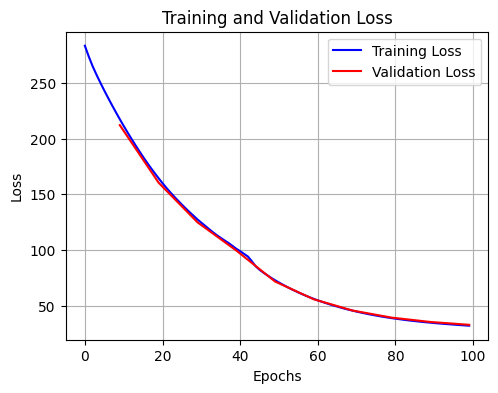

In [6]:

# Model setup
input_size = 12
hidden_size = 512
num_layers = 1
model = LSTM_custom(input_size=input_size, hidden_size=hidden_size,
                    num_layers=num_layers).to(device)

num_epochs = 100
best_val_loss = float('inf')


criterion = RMSELoss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Change to CosineAnnealingLR
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0.0001)

import matplotlib.pyplot as plt

# Initialize empty lists to store losses and learning rates
train_losses = []
val_losses = []
learning_rates = []

# Training loop with validation


for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    
    for inputs, targets in train_dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_dataloader)
    
    # Validation phase every 10 epochs
    if (epoch + 1) % 10 == 0:
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_dataloader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_dataloader)
    else:
        avg_val_loss = None
    
    # Step the learning rate scheduler
    lr_scheduler.step()
    
    # Track metrics
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    learning_rates.append(optimizer.param_groups[0]['lr'])
    
    # Print metrics every 5 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, "
              f"LR: {optimizer.param_groups[0]['lr']:.6f}")


# Plot losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-', label='Training Loss')
# Plot validation losses only for epochs where validation was done
val_epochs = [i for i, v in enumerate(val_losses) if v is not None]
val_losses_filtered = [v for v in val_losses if v is not None]
plt.plot(val_epochs, val_losses_filtered, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)


In [7]:
# AFTER TRAINING: Final evaluation on test set
model.eval()
with torch.no_grad():
    test_loss = 0
    for inputs, targets in test_dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        test_loss += criterion(outputs, targets).item()
    
    avg_test_loss = test_loss / len(test_dataloader)
    print(f"Test Loss: {avg_test_loss:.4f}")


Test Loss: 34.9839


# With Dropout

In [8]:
class LSTM_custom(nn.Module):
    def __init__(
        self,
        input_size=12,
        hidden_size=64,
        num_layers=1,
        sequence_length=62,
        dropout=0.2,
    ):
        super(LSTM_custom, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout_rate = dropout
        self.projection_layer = nn.Linear(self.hidden_size, input_size)
        self.dropout = nn.Dropout(dropout)  # Add dropout layer

        # Input gate
        self.W_xi = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(input_size, hidden_size)))
        self.b_xi = nn.Parameter(torch.zeros(hidden_size))
        self.W_hi = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(hidden_size, hidden_size)))
        self.b_hi = nn.Parameter(torch.zeros(hidden_size))

        # Forget gate
        self.W_xf = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(input_size, hidden_size)))
        self.b_xf = nn.Parameter(torch.zeros(hidden_size))
        self.W_hf = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(hidden_size, hidden_size)))
        self.b_hf = nn.Parameter(torch.zeros(hidden_size))

        # Cell gate
        self.W_xg = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(input_size, hidden_size)))
        self.b_xg = nn.Parameter(torch.zeros(hidden_size))
        self.W_hg = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(hidden_size, hidden_size)))
        self.b_hg = nn.Parameter(torch.zeros(hidden_size))

        # Output gate
        self.W_xo = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(input_size, hidden_size)))
        self.b_xo = nn.Parameter(torch.zeros(hidden_size))
        self.W_ho = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(hidden_size, hidden_size)))
        self.b_ho = nn.Parameter(torch.zeros(hidden_size))

    def input_gate(self, x_t, h_prev):
        return torch.sigmoid(
            torch.matmul(x_t, self.W_xi) + self.b_xi + torch.matmul(h_prev, self.W_hi) + self.b_hi
        )

    def forget_gate(self, x_t, h_prev):
        return torch.sigmoid(
            torch.matmul(x_t, self.W_xf) + self.b_xf + torch.matmul(h_prev, self.W_hf) + self.b_hf
        )

    def cell_gate(self, x_t, h_prev):
        return torch.tanh(
            torch.matmul(x_t, self.W_xg) + self.b_xg + torch.matmul(h_prev, self.W_hg) + self.b_hg
        )

    def output_gate(self, x_t, h_prev):
        return torch.sigmoid(
            torch.matmul(x_t, self.W_xo) + self.b_xo + torch.matmul(h_prev, self.W_ho) + self.b_ho
        )

    def lstm_cell(self, x_t, h_prev, c_prev):
        i_t = self.input_gate(x_t, h_prev)
        f_t = self.forget_gate(x_t, h_prev)
        g_t = self.cell_gate(x_t, h_prev)
        o_t = self.output_gate(x_t, h_prev)

        c_t = f_t * c_prev + i_t * g_t
        h_t = o_t * torch.tanh(c_t)
        h_t = self.dropout(h_t)
        return h_t, c_t

    def forward(self, x):
        batch_size, seq_len, feature_dim = x.size()
        h_t = torch.zeros(batch_size, self.hidden_size, device=x.device)
        c_t = torch.zeros(batch_size, self.hidden_size, device=x.device)

        # Process the input sequence
        for t in range(seq_len):
            h_t, c_t = self.lstm_cell(x[:, t, :], h_t, c_t)

        # Generate predictions
        predictions = []
        current_x = x[:, -1, :]  # Start with the last input

        for i in range(5):
            h_t, c_t = self.lstm_cell(current_x, h_t, c_t)
            # Project hidden state to feature dimension
            output = self.projection_layer(h_t)
            predictions.append(output)
            current_x = output  # Use the prediction as the next input

        # Stack predictions along sequence dimension
        return torch.stack(predictions, dim=1)


In [9]:
def RMSELoss(y_pred, y_true):
    # return torch.sqrt(torch.mean((y_pred - y_true) ** 2) + 1e-8)
    return torch.sqrt(nn.MSELoss()(y_pred, y_true) + 1e-8)


Epoch [10/100], Train Loss: 217.6369, Val Loss: 212.2876, LR: 0.000978
Epoch [20/100], Train Loss: 163.2762, Val Loss: 158.9808, LR: 0.000914
Epoch [30/100], Train Loss: 120.7415, Val Loss: 117.4964, LR: 0.000815
Epoch [40/100], Train Loss: 90.1093, Val Loss: 87.9685, LR: 0.000689
Epoch [50/100], Train Loss: 69.3749, Val Loss: 68.2217, LR: 0.000550
Epoch [60/100], Train Loss: 55.9718, Val Loss: 55.1894, LR: 0.000411
Epoch [70/100], Train Loss: 47.3544, Val Loss: 46.9784, LR: 0.000285
Epoch [80/100], Train Loss: 42.2276, Val Loss: 41.8792, LR: 0.000186
Epoch [90/100], Train Loss: 39.1812, Val Loss: 38.9146, LR: 0.000122
Epoch [100/100], Train Loss: 37.2792, Val Loss: 36.9562, LR: 0.000100


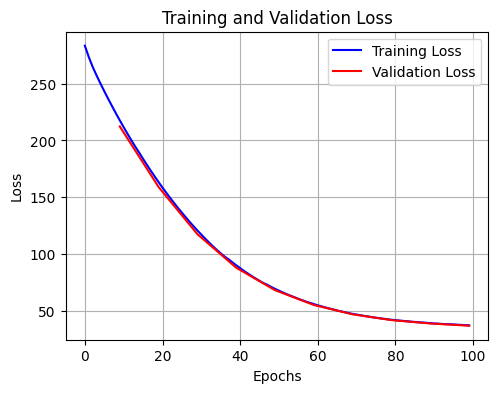

In [10]:

# Model setup
input_size = 12
hidden_size = 512
num_layers = 1
model = LSTM_custom(input_size=input_size, hidden_size=hidden_size,
                    num_layers=num_layers).to(device)

num_epochs = 100
best_val_loss = float('inf')


criterion = RMSELoss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001, amsgrad=True)

# Change to CosineAnnealingLR
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0.0001)

import matplotlib.pyplot as plt

# Initialize empty lists to store losses and learning rates
train_losses = []
val_losses = []
learning_rates = []

# Training loop with validation


for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    
    for inputs, targets in train_dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_dataloader)
    
    # Validation phase every 10 epochs
    if (epoch + 1) % 10 == 0:
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_dataloader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_dataloader)
    else:
        avg_val_loss = None
    
    # Step the learning rate scheduler
    lr_scheduler.step()
    
    # Track metrics
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    learning_rates.append(optimizer.param_groups[0]['lr'])
    
    # Print metrics every 5 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, "
              f"LR: {optimizer.param_groups[0]['lr']:.6f}")


# Plot losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-', label='Training Loss')
# Plot validation losses only for epochs where validation was done
val_epochs = [i for i, v in enumerate(val_losses) if v is not None]
val_losses_filtered = [v for v in val_losses if v is not None]
plt.plot(val_epochs, val_losses_filtered, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)


In [11]:
# AFTER TRAINING: Final evaluation on test set
model.eval()
with torch.no_grad():
    test_loss = 0
    for inputs, targets in test_dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        test_loss += criterion(outputs, targets).item()
    
    avg_test_loss = test_loss / len(test_dataloader)
    print(f"Test Loss: {avg_test_loss:.4f}")


Test Loss: 39.5626


# With Weight Decay and ams grad

Epoch [10/100], Train Loss: 217.7195, Val Loss: 212.3609, LR: 0.000978
Epoch [20/100], Train Loss: 162.6458, Val Loss: 158.3408, LR: 0.000914
Epoch [30/100], Train Loss: 119.8920, Val Loss: 116.6989, LR: 0.000815
Epoch [40/100], Train Loss: 88.9421, Val Loss: 86.7787, LR: 0.000689
Epoch [50/100], Train Loss: 68.0452, Val Loss: 66.7617, LR: 0.000550
Epoch [60/100], Train Loss: 54.5524, Val Loss: 53.7369, LR: 0.000411
Epoch [70/100], Train Loss: 46.0030, Val Loss: 45.4477, LR: 0.000285
Epoch [80/100], Train Loss: 41.0513, Val Loss: 40.6556, LR: 0.000186
Epoch [90/100], Train Loss: 38.1808, Val Loss: 37.8141, LR: 0.000122
Epoch [100/100], Train Loss: 36.2277, Val Loss: 35.9697, LR: 0.000100


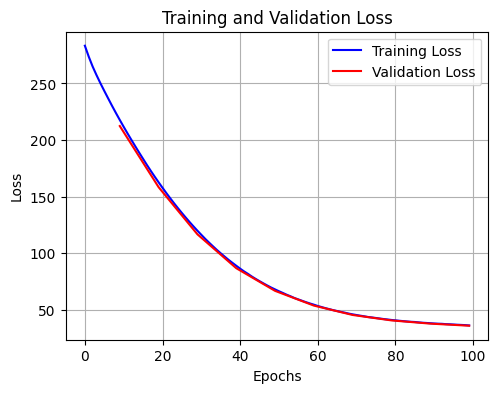

In [12]:

# Model setup
input_size = 12
hidden_size = 512
num_layers = 1
model = LSTM_custom(input_size=input_size, hidden_size=hidden_size,
                    num_layers=num_layers).to(device)

num_epochs = 100
best_val_loss = float('inf')


criterion = RMSELoss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001, amsgrad=True)

# Change to CosineAnnealingLR
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0.0001)

import matplotlib.pyplot as plt

# Initialize empty lists to store losses and learning rates
train_losses = []
val_losses = []
learning_rates = []

# Training loop with validation


for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    
    for inputs, targets in train_dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_dataloader)
    
    # Validation phase every 10 epochs
    if (epoch + 1) % 10 == 0:
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_dataloader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_dataloader)
    else:
        avg_val_loss = None
    
    # Step the learning rate scheduler
    lr_scheduler.step()
    
    # Track metrics
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    learning_rates.append(optimizer.param_groups[0]['lr'])
    
    # Print metrics every 5 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, "
              f"LR: {optimizer.param_groups[0]['lr']:.6f}")


# Plot losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-', label='Training Loss')
# Plot validation losses only for epochs where validation was done
val_epochs = [i for i, v in enumerate(val_losses) if v is not None]
val_losses_filtered = [v for v in val_losses if v is not None]
plt.plot(val_epochs, val_losses_filtered, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)


In [13]:
# AFTER TRAINING: Final evaluation on test set
model.eval()
with torch.no_grad():
    test_loss = 0
    for inputs, targets in test_dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        test_loss += criterion(outputs, targets).item()
    
    avg_test_loss = test_loss / len(test_dataloader)
    print(f"Test Loss: {avg_test_loss:.4f}")


Test Loss: 38.5264


# With Dropout

In [14]:
class LSTM_custom(nn.Module):
    def __init__(
        self,
        input_size=12,
        hidden_size=64,
        num_layers=1,
        sequence_length=62,
        dropout=0.2,
    ):
        super(LSTM_custom, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout_rate = dropout
        self.projection_layer = nn.Linear(self.hidden_size, input_size)
        self.dropout = nn.Dropout(dropout)  # Add dropout layer

        # Input gate
        self.W_xi = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(input_size, hidden_size)))
        self.b_xi = nn.Parameter(torch.zeros(hidden_size))
        self.W_hi = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(hidden_size, hidden_size)))
        self.b_hi = nn.Parameter(torch.zeros(hidden_size))

        # Forget gate
        self.W_xf = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(input_size, hidden_size)))
        self.b_xf = nn.Parameter(torch.zeros(hidden_size))
        self.W_hf = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(hidden_size, hidden_size)))
        self.b_hf = nn.Parameter(torch.zeros(hidden_size))

        # Cell gate
        self.W_xg = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(input_size, hidden_size)))
        self.b_xg = nn.Parameter(torch.zeros(hidden_size))
        self.W_hg = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(hidden_size, hidden_size)))
        self.b_hg = nn.Parameter(torch.zeros(hidden_size))

        # Output gate
        self.W_xo = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(input_size, hidden_size)))
        self.b_xo = nn.Parameter(torch.zeros(hidden_size))
        self.W_ho = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(hidden_size, hidden_size)))
        self.b_ho = nn.Parameter(torch.zeros(hidden_size))

    def input_gate(self, x_t, h_prev):
        return torch.sigmoid(
            torch.matmul(x_t, self.W_xi) + self.b_xi + torch.matmul(h_prev, self.W_hi) + self.b_hi
        )

    def forget_gate(self, x_t, h_prev):
        return torch.sigmoid(
            torch.matmul(x_t, self.W_xf) + self.b_xf + torch.matmul(h_prev, self.W_hf) + self.b_hf
        )

    def cell_gate(self, x_t, h_prev):
        return torch.tanh(
            torch.matmul(x_t, self.W_xg) + self.b_xg + torch.matmul(h_prev, self.W_hg) + self.b_hg
        )

    def output_gate(self, x_t, h_prev):
        return torch.sigmoid(
            torch.matmul(x_t, self.W_xo) + self.b_xo + torch.matmul(h_prev, self.W_ho) + self.b_ho
        )

    def lstm_cell(self, x_t, h_prev, c_prev):
        i_t = self.input_gate(x_t, h_prev)
        f_t = self.forget_gate(x_t, h_prev)
        g_t = self.cell_gate(x_t, h_prev)
        o_t = self.output_gate(x_t, h_prev)

        c_t = f_t * c_prev + i_t * g_t
        h_t = o_t * torch.tanh(c_t)
        h_t = self.dropout(h_t)
        return h_t, c_t

    def forward(self, x):
        batch_size, seq_len, feature_dim = x.size()
        h_t = torch.zeros(batch_size, self.hidden_size, device=x.device)
        c_t = torch.zeros(batch_size, self.hidden_size, device=x.device)

        # Process the input sequence
        for t in range(seq_len):
            h_t, c_t = self.lstm_cell(x[:, t, :], h_t, c_t)

        # Generate predictions
        predictions = []
        current_x = x[:, -1, :]  # Start with the last input

        for i in range(5):
            h_t, c_t = self.lstm_cell(current_x, h_t, c_t)
            # Project hidden state to feature dimension
            output = self.projection_layer(h_t)
            predictions.append(output)
            current_x = output  # Use the prediction as the next input

        # Stack predictions along sequence dimension
        return torch.stack(predictions, dim=1)


In [15]:
def RMSELoss(y_pred, y_true):
    # return torch.sqrt(torch.mean((y_pred - y_true) ** 2) + 1e-8)
    return torch.sqrt(nn.MSELoss()(y_pred, y_true) + 1e-8)


Epoch [10/100], Train Loss: 216.8494, Val Loss: 211.4872, LR: 0.000978
Epoch [20/100], Train Loss: 161.6230, Val Loss: 157.3255, LR: 0.000914
Epoch [30/100], Train Loss: 119.6217, Val Loss: 116.3461, LR: 0.000815
Epoch [40/100], Train Loss: 88.6326, Val Loss: 86.4892, LR: 0.000689
Epoch [50/100], Train Loss: 68.0237, Val Loss: 66.7260, LR: 0.000550
Epoch [60/100], Train Loss: 55.1397, Val Loss: 54.2396, LR: 0.000411
Epoch [70/100], Train Loss: 46.7927, Val Loss: 46.0763, LR: 0.000285
Epoch [80/100], Train Loss: 41.8135, Val Loss: 41.2427, LR: 0.000186
Epoch [90/100], Train Loss: 38.9246, Val Loss: 38.3503, LR: 0.000122
Epoch [100/100], Train Loss: 37.0300, Val Loss: 36.5011, LR: 0.000100


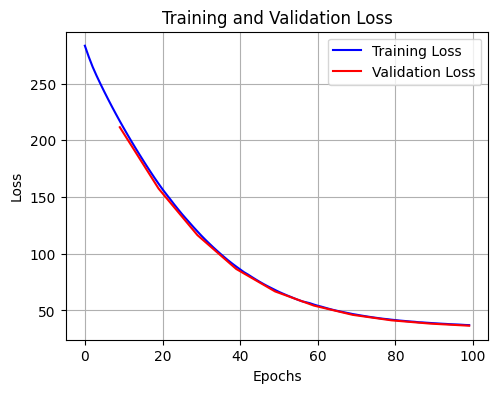

In [ ]:

# Model setup
import matplotlib.pyplot as plt
input_size = 12
hidden_size = 512
model = LSTM_custom(input_size=input_size, hidden_size=hidden_size).to(device)

num_epochs = 100
best_val_loss = float('inf')


criterion = RMSELoss
optimizer = torch.optim.Adam(
    model.parameters(), lr=0.001, weight_decay=0.0001, amsgrad=True)

# Change to CosineAnnealingLR
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=num_epochs, eta_min=0.0001)


# Initialize empty lists to store losses and learning rates
train_losses = []
val_losses = []
learning_rates = []

# Training loop with validation


for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0

    for inputs, targets in train_dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_dataloader)

    # Validation phase every 10 epochs
    if (epoch + 1) % 10 == 0:
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_dataloader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_dataloader)
    else:
        avg_val_loss = None

    # Step the learning rate scheduler
    lr_scheduler.step()

    # Track metrics
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    learning_rates.append(optimizer.param_groups[0]['lr'])

    # Print metrics every 5 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, "
              f"LR: {optimizer.param_groups[0]['lr']:.6f}")


# Plot losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-', label='Training Loss')
# Plot validation losses only for epochs where validation was done
val_epochs = [i for i, v in enumerate(val_losses) if v is not None]
val_losses_filtered = [v for v in val_losses if v is not None]
plt.plot(val_epochs, val_losses_filtered, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

In [17]:
# AFTER TRAINING: Final evaluation on test set
model.eval()
with torch.no_grad():
    test_loss = 0
    for inputs, targets in test_dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        test_loss += criterion(outputs, targets).item()
    
    avg_test_loss = test_loss / len(test_dataloader)
    print(f"Test Loss: {avg_test_loss:.4f}")


Test Loss: 39.2711


# more epochs

Epoch [10/150], Train Loss: 217.4031, Val Loss: 211.9612, LR: 0.000990
Epoch [20/150], Train Loss: 161.2597, Val Loss: 156.8591, LR: 0.000961
Epoch [30/150], Train Loss: 115.6881, Val Loss: 112.3972, LR: 0.000914
Epoch [40/150], Train Loss: 81.2094, Val Loss: 79.1233, LR: 0.000851
Epoch [50/150], Train Loss: 57.5847, Val Loss: 56.3574, LR: 0.000775
Epoch [60/150], Train Loss: 42.4678, Val Loss: 41.6656, LR: 0.000689
Epoch [70/150], Train Loss: 32.9004, Val Loss: 32.1001, LR: 0.000597
Epoch [80/150], Train Loss: 26.7761, Val Loss: 26.0126, LR: 0.000503
Epoch [90/150], Train Loss: 23.0979, Val Loss: 22.3576, LR: 0.000411
Epoch [100/150], Train Loss: 21.0891, Val Loss: 20.4230, LR: 0.000325
Epoch [110/150], Train Loss: 19.8302, Val Loss: 18.9238, LR: 0.000249
Epoch [120/150], Train Loss: 19.0667, Val Loss: 18.2691, LR: 0.000186
Epoch [130/150], Train Loss: 18.5476, Val Loss: 17.6227, LR: 0.000139
Epoch [140/150], Train Loss: 18.1326, Val Loss: 17.1046, LR: 0.000110
Epoch [150/150], Train 

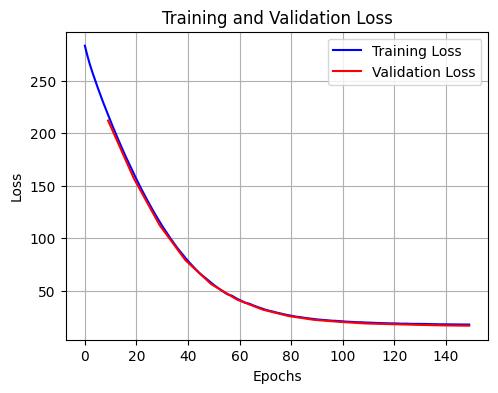

In [18]:

# Model setup
import matplotlib.pyplot as plt
input_size = 12
hidden_size = 512
model = LSTM_custom(input_size=input_size, hidden_size=hidden_size).to(device)

num_epochs = 150
best_val_loss = float('inf')


criterion = RMSELoss
optimizer = torch.optim.Adam(
    model.parameters(), lr=0.001, weight_decay=0.0001, amsgrad=True)

# Change to CosineAnnealingLR
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=num_epochs, eta_min=0.0001)


# Initialize empty lists to store losses and learning rates
train_losses = []
val_losses = []
learning_rates = []

# Training loop with validation


for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0

    for inputs, targets in train_dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_dataloader)

    # Validation phase every 10 epochs
    if (epoch + 1) % 10 == 0:
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_dataloader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_dataloader)
    else:
        avg_val_loss = None

    # Step the learning rate scheduler
    lr_scheduler.step()

    # Track metrics
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    learning_rates.append(optimizer.param_groups[0]['lr'])

    # Print metrics every 5 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, "
              f"LR: {optimizer.param_groups[0]['lr']:.6f}")


# Plot losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-', label='Training Loss')
# Plot validation losses only for epochs where validation was done
val_epochs = [i for i, v in enumerate(val_losses) if v is not None]
val_losses_filtered = [v for v in val_losses if v is not None]
plt.plot(val_epochs, val_losses_filtered, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

In [19]:
# AFTER TRAINING: Final evaluation on test set
model.eval()
with torch.no_grad():
    test_loss = 0
    for inputs, targets in test_dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        test_loss += criterion(outputs, targets).item()
    
    avg_test_loss = test_loss / len(test_dataloader)
    print(f"Test Loss: {avg_test_loss:.4f}")


Test Loss: 16.5448


# 1024

In [ ]:
class LSTM_custom(nn.Module):
    def __init__(
        self,
        input_size=12,
        hidden_size=64,
        num_layers=1,
        sequence_length=62,
        dropout=0.2,
    ):
        super(LSTM_custom, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout_rate = dropout
        self.projection_layer = nn.Linear(self.hidden_size, input_size)
        self.dropout = nn.Dropout(dropout)  # Add dropout layer

        # Input gate
        self.W_xi = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(input_size, hidden_size)))
        self.b_xi = nn.Parameter(torch.zeros(hidden_size))
        self.W_hi = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(hidden_size, hidden_size)))
        self.b_hi = nn.Parameter(torch.zeros(hidden_size))

        # Forget gate
        self.W_xf = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(input_size, hidden_size)))
        self.b_xf = nn.Parameter(torch.zeros(hidden_size))
        self.W_hf = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(hidden_size, hidden_size)))
        self.b_hf = nn.Parameter(torch.zeros(hidden_size))

        # Cell gate
        self.W_xg = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(input_size, hidden_size)))
        self.b_xg = nn.Parameter(torch.zeros(hidden_size))
        self.W_hg = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(hidden_size, hidden_size)))
        self.b_hg = nn.Parameter(torch.zeros(hidden_size))

        # Output gate
        self.W_xo = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(input_size, hidden_size)))
        self.b_xo = nn.Parameter(torch.zeros(hidden_size))
        self.W_ho = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(hidden_size, hidden_size)))
        self.b_ho = nn.Parameter(torch.zeros(hidden_size))

    def input_gate(self, x_t, h_prev):
        return torch.sigmoid(
            torch.matmul(x_t, self.W_xi) + self.b_xi + torch.matmul(h_prev, self.W_hi) + self.b_hi
        )

    def forget_gate(self, x_t, h_prev):
        return torch.sigmoid(
            torch.matmul(x_t, self.W_xf) + self.b_xf + torch.matmul(h_prev, self.W_hf) + self.b_hf
        )

    def cell_gate(self, x_t, h_prev):
        return torch.tanh(
            torch.matmul(x_t, self.W_xg) + self.b_xg + torch.matmul(h_prev, self.W_hg) + self.b_hg
        )

    def output_gate(self, x_t, h_prev):
        return torch.sigmoid(
            torch.matmul(x_t, self.W_xo) + self.b_xo + torch.matmul(h_prev, self.W_ho) + self.b_ho
        )

    def lstm_cell(self, x_t, h_prev, c_prev):
        i_t = self.input_gate(x_t, h_prev)
        f_t = self.forget_gate(x_t, h_prev)
        g_t = self.cell_gate(x_t, h_prev)
        o_t = self.output_gate(x_t, h_prev)

        c_t = f_t * c_prev + i_t * g_t
        h_t = o_t * torch.tanh(c_t)
        h_t = self.dropout(h_t)
        return h_t, c_t

    def forward(self, x):
        batch_size, seq_len, feature_dim = x.size()
        h_t = torch.zeros(batch_size, self.hidden_size, device=x.device)
        c_t = torch.zeros(batch_size, self.hidden_size, device=x.device)

        # Process the input sequence
        for t in range(seq_len):
            h_t, c_t = self.lstm_cell(x[:, t, :], h_t, c_t)

        # Generate predictions
        predictions = []
        current_x = x[:, -1, :]  # Start with the last input

        for i in range(5):
            h_t, c_t = self.lstm_cell(current_x, h_t, c_t)
            # Project hidden state to feature dimension
            output = self.projection_layer(h_t)
            predictions.append(output)
            current_x = output  # Use the prediction as the next input

        # Stack predictions along sequence dimension
        return torch.stack(predictions, dim=1)


In [21]:
def RMSELoss(y_pred, y_true):
    # return torch.sqrt(torch.mean((y_pred - y_true) ** 2) + 1e-8)
    return torch.sqrt(nn.MSELoss()(y_pred, y_true) + 1e-8)


Epoch [10/100], Train Loss: 163.4386, Val Loss: 156.4808, LR: 0.000978
Epoch [20/100], Train Loss: 80.7664, Val Loss: 77.2351, LR: 0.000914
Epoch [30/100], Train Loss: 37.6079, Val Loss: 36.5871, LR: 0.000815
Epoch [40/100], Train Loss: 21.2868, Val Loss: 20.9848, LR: 0.000689
Epoch [50/100], Train Loss: 17.0594, Val Loss: 16.9368, LR: 0.000550
Epoch [60/100], Train Loss: 15.2030, Val Loss: 15.2635, LR: 0.000411
Epoch [70/100], Train Loss: 14.6100, Val Loss: 14.6163, LR: 0.000285
Epoch [80/100], Train Loss: 14.1561, Val Loss: 14.3334, LR: 0.000186
Epoch [90/100], Train Loss: 13.9043, Val Loss: 14.1180, LR: 0.000122
Epoch [100/100], Train Loss: 13.7294, Val Loss: 13.9139, LR: 0.000100


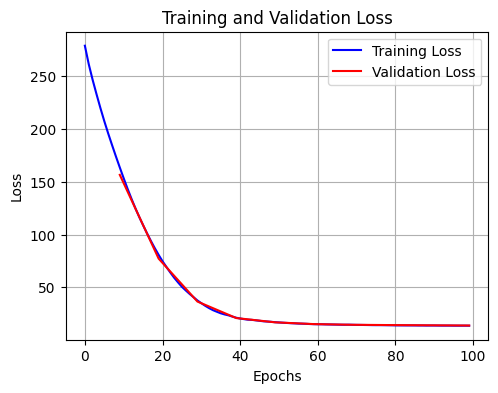

In [22]:

# Model setup
import matplotlib.pyplot as plt
input_size = 12
hidden_size = 1024
model = LSTM_custom(input_size=input_size, hidden_size=hidden_size).to(device)

num_epochs = 100
best_val_loss = float('inf')


criterion = RMSELoss
optimizer = torch.optim.Adam(
    model.parameters(), lr=0.001, weight_decay=0.0001, amsgrad=True)

# Change to CosineAnnealingLR
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=num_epochs, eta_min=0.0001)


# Initialize empty lists to store losses and learning rates
train_losses = []
val_losses = []
learning_rates = []

# Training loop with validation


for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0

    for inputs, targets in train_dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_dataloader)

    # Validation phase every 10 epochs
    if (epoch + 1) % 10 == 0:
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_dataloader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_dataloader)
    else:
        avg_val_loss = None

    # Step the learning rate scheduler
    lr_scheduler.step()

    # Track metrics
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    learning_rates.append(optimizer.param_groups[0]['lr'])

    # Print metrics every 5 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, "
              f"LR: {optimizer.param_groups[0]['lr']:.6f}")


# Plot losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-', label='Training Loss')
# Plot validation losses only for epochs where validation was done
val_epochs = [i for i, v in enumerate(val_losses) if v is not None]
val_losses_filtered = [v for v in val_losses if v is not None]
plt.plot(val_epochs, val_losses_filtered, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

In [23]:
# AFTER TRAINING: Final evaluation on test set
model.eval()
with torch.no_grad():
    test_loss = 0
    for inputs, targets in test_dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        test_loss += criterion(outputs, targets).item()
    
    avg_test_loss = test_loss / len(test_dataloader)
    print(f"Test Loss: {avg_test_loss:.4f}")


Test Loss: 12.2698


# trying something

In [32]:
class LSTM_custom(nn.Module):
    def __init__(
        self,
        input_size=12,
        hidden_size=64,
        num_layers=1,
        sequence_length=62,
        dropout=0.2,
    ):
        super(LSTM_custom, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.projection_layer = nn.Linear(self.hidden_size, input_size)

        # Input gate
        self.W_xi = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(input_size, hidden_size)))
        self.b_xi = nn.Parameter(torch.zeros(hidden_size))
        self.W_hi = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(hidden_size, hidden_size)))
        self.b_hi = nn.Parameter(torch.zeros(hidden_size))

        # Forget gate
        self.W_xf = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(input_size, hidden_size)))
        self.b_xf = nn.Parameter(torch.zeros(hidden_size))
        self.W_hf = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(hidden_size, hidden_size)))
        self.b_hf = nn.Parameter(torch.zeros(hidden_size))

        # Cell gate
        self.W_xg = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(input_size, hidden_size)))
        self.b_xg = nn.Parameter(torch.zeros(hidden_size))
        self.W_hg = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(hidden_size, hidden_size)))
        self.b_hg = nn.Parameter(torch.zeros(hidden_size))

        # Output gate
        self.W_xo = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(input_size, hidden_size)))
        self.b_xo = nn.Parameter(torch.zeros(hidden_size))
        self.W_ho = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(hidden_size, hidden_size)))
        self.b_ho = nn.Parameter(torch.zeros(hidden_size))

    def input_gate(self, x_t, h_prev):
        return torch.sigmoid(
            torch.matmul(x_t, self.W_xi) + self.b_xi + torch.matmul(h_prev, self.W_hi) + self.b_hi
        )

    def forget_gate(self, x_t, h_prev):
        return torch.sigmoid(
            torch.matmul(x_t, self.W_xf) + self.b_xf + torch.matmul(h_prev, self.W_hf) + self.b_hf
        )

    def cell_gate(self, x_t, h_prev):
        return torch.tanh(
            torch.matmul(x_t, self.W_xg) + self.b_xg + torch.matmul(h_prev, self.W_hg) + self.b_hg
        )

    def output_gate(self, x_t, h_prev):
        return torch.sigmoid(
            torch.matmul(x_t, self.W_xo) + self.b_xo + torch.matmul(h_prev, self.W_ho) + self.b_ho
        )

    def lstm_cell(self, x_t, h_prev, c_prev):
        i_t = self.input_gate(x_t, h_prev)
        f_t = self.forget_gate(x_t, h_prev)
        g_t = self.cell_gate(x_t, h_prev)
        o_t = self.output_gate(x_t, h_prev)

        c_t = f_t * c_prev + i_t * g_t
        h_t = o_t * torch.tanh(c_t)

        return h_t, c_t

    def forward(self, x):
        batch_size, seq_len, feature_dim = x.size()
        h_t = torch.zeros(batch_size, self.hidden_size, device=x.device)
        c_t = torch.zeros(batch_size, self.hidden_size, device=x.device)

        # Process the input sequence
        for t in range(seq_len):
            h_t, c_t = self.lstm_cell(x[:, t, :], h_t, c_t)

        # Generate predictions
        predictions = []
        current_x = x[:, -1, :]  # Start with the last input

        for i in range(5):
            h_t, c_t = self.lstm_cell(current_x, h_t, c_t)
            # Project hidden state to feature dimension
            output = self.projection_layer(h_t)
            predictions.append(output)
            current_x = output  # Use the prediction as the next input

        # Stack predictions along sequence dimension
        return torch.stack(predictions, dim=1)


In [33]:
# class LSTM_custom(nn.Module):
#     def __init__(
#         self,
#         input_size=12,
#         hidden_size=64,
#         num_layers=1,
#         sequence_length=62,
#         dropout=0.2,
#     ):
#         super(LSTM_custom, self).__init__()
#         self.input_size = input_size
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.projection_layer = nn.Linear(self.hidden_size, input_size)

#         # Combined input+hidden dimension
#         combined_dim = input_size + hidden_size
        
#         # Input gate
#         self.W_i = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(combined_dim, hidden_size)))
#         self.b_i = nn.Parameter(torch.zeros(hidden_size))
        
#         # Forget gate
#         self.W_f = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(combined_dim, hidden_size)))
#         self.b_f = nn.Parameter(torch.ones(hidden_size))  # Initialize to 1 for better gradient flow
        
#         # Cell gate
#         self.W_g = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(combined_dim, hidden_size)))
#         self.b_g = nn.Parameter(torch.zeros(hidden_size))
        
#         # Output gate
#         self.W_o = nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(combined_dim, hidden_size)))
#         self.b_o = nn.Parameter(torch.zeros(hidden_size))

#     def input_gate(self, x_t, h_prev):
#         # Concatenate input and hidden state
#         combined = torch.cat([x_t, h_prev], dim=1)
#         return torch.sigmoid(torch.matmul(combined, self.W_i) + self.b_i)

#     def forget_gate(self, x_t, h_prev):
#         combined = torch.cat([x_t, h_prev], dim=1)
#         return torch.sigmoid(torch.matmul(combined, self.W_f) + self.b_f)

#     def cell_gate(self, x_t, h_prev):
#         combined = torch.cat([x_t, h_prev], dim=1)
#         return torch.tanh(torch.matmul(combined, self.W_g) + self.b_g)

#     def output_gate(self, x_t, h_prev):
#         combined = torch.cat([x_t, h_prev], dim=1)
#         return torch.sigmoid(torch.matmul(combined, self.W_o) + self.b_o)

#     def lstm_cell(self, x_t, h_prev, c_prev):
#         i_t = self.input_gate(x_t, h_prev)
#         f_t = self.forget_gate(x_t, h_prev)
#         g_t = self.cell_gate(x_t, h_prev)
#         o_t = self.output_gate(x_t, h_prev)

#         c_t = f_t * c_prev + i_t * g_t
#         h_t = o_t * torch.tanh(c_t)

#         return h_t, c_t

#     def forward(self, x):
#         batch_size, seq_len, feature_dim = x.size()
#         h_t = torch.zeros(batch_size, self.hidden_size, device=x.device)
#         c_t = torch.zeros(batch_size, self.hidden_size, device=x.device)

#         # Process the input sequence
#         for t in range(seq_len):
#             h_t, c_t = self.lstm_cell(x[:, t, :], h_t, c_t)

#         # Generate predictions
#         predictions = []
#         current_x = x[:, -1, :]  # Start with the last input

#         for i in range(5):
#             h_t, c_t = self.lstm_cell(current_x, h_t, c_t)
#             # Project hidden state to feature dimension
#             output = self.projection_layer(h_t)
#             predictions.append(output)
#             current_x = output  # Use the prediction as the next input

#         # Stack predictions along sequence dimension
#         return torch.stack(predictions, dim=1)


In [34]:
def RMSELoss(y_pred, y_true):
    # return torch.sqrt(torch.mean((y_pred - y_true) ** 2) + 1e-8)
    return torch.sqrt(nn.MSELoss()(y_pred[..., :2], y_true[..., :2]) + 1e-8)


Epoch [10/100], Train Loss: 526.6761, Val Loss: 513.5223, LR: 0.000978
Epoch [20/100], Train Loss: 387.9135, Val Loss: 377.6338, LR: 0.000914
Epoch [30/100], Train Loss: 281.6789, Val Loss: 274.3665, LR: 0.000815
Epoch [40/100], Train Loss: 202.6959, Val Loss: 198.2338, LR: 0.000689
Epoch [50/100], Train Loss: 146.7329, Val Loss: 144.6670, LR: 0.000550
Epoch [60/100], Train Loss: 108.6301, Val Loss: 108.2709, LR: 0.000411
Epoch [70/100], Train Loss: 83.8858, Val Loss: 84.6113, LR: 0.000285
Epoch [80/100], Train Loss: 68.2540, Val Loss: 69.8595, LR: 0.000186
Epoch [90/100], Train Loss: 58.5311, Val Loss: 60.2414, LR: 0.000122
Epoch [100/100], Train Loss: 51.8803, Val Loss: 53.8305, LR: 0.000100


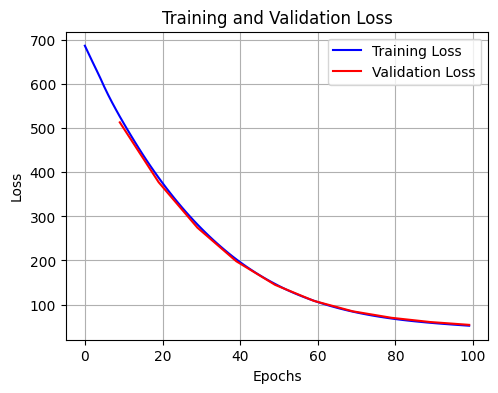

In [35]:

# Model setup
input_size = 12
hidden_size = 512
num_layers = 1
model = LSTM_custom(input_size=input_size, hidden_size=hidden_size,
                    num_layers=num_layers).to(device)

num_epochs = 100
best_val_loss = float('inf')


criterion = RMSELoss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Change to CosineAnnealingLR
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0.0001)

import matplotlib.pyplot as plt

# Initialize empty lists to store losses and learning rates
train_losses = []
val_losses = []
learning_rates = []

# Training loop with validation


for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    
    for inputs, targets in train_dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_dataloader)
    
    # Validation phase every 10 epochs
    if (epoch + 1) % 10 == 0:
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_dataloader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_dataloader)
    else:
        avg_val_loss = None
    
    # Step the learning rate scheduler
    lr_scheduler.step()
    
    # Track metrics
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    learning_rates.append(optimizer.param_groups[0]['lr'])
    
    # Print metrics every 5 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, "
              f"LR: {optimizer.param_groups[0]['lr']:.6f}")


# Plot losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-', label='Training Loss')
# Plot validation losses only for epochs where validation was done
val_epochs = [i for i, v in enumerate(val_losses) if v is not None]
val_losses_filtered = [v for v in val_losses if v is not None]
plt.plot(val_epochs, val_losses_filtered, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)


In [ ]:
# AFTER TRAINING: Final evaluation on test set
model.eval()
with torch.no_grad():
    test_loss = 0
    for inputs, targets in test_dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        test_loss += criterion(outputs, targets).item()
    
    avg_test_loss = test_loss / len(test_dataloader)
    print(f"Test Loss: {avg_test_loss:.4f}")


Test Loss: 59.0913
